In [1]:
%load_ext autoreload
%autoreload 2

In [151]:
def unit_test_rectangles():
    import numpy as np
    import matplotlib.pyplot as plt
    from groups import get_rectangles
    
    np.random.seed(123)

    X1 = np.random.choice([0,1], size=(3,)) 
    X2 = np.random.choice(np.arange(2), size=(3,))

    X = np.stack((X1, X2), axis=1)
    
    rects = get_rectangles(X)
    
    true_rects = np.asarray([
        [False, True, True], 
        [True, False, True], 
        [False, True, True]
    ])
    return (rects == true_rects).all()

def unit_test_intervals():
    # verify that rectangles score matches interval score
    import numpy as np
    from auditor import Auditor
    from metrics import Metric
    from groups import get_rectangles
    from scipy.stats import norm

    rng = np.random.default_rng(seed = 0)
    n_samples = 200

    X = rng.uniform(0, 5, (n_samples,1))
    Y = X + 0.1 * rng.standard_normal(size=(n_samples,1))
    Z1 = X - norm.ppf(0.95, scale=0.1)
    Z2 = X + norm.ppf(0.95, scale=0.1)
    Z = np.hstack([Z1, Z2])

    metric = Metric("equalized_coverage")

    auditor = Auditor(X=X, Y=Y, Z=Z, metric=metric)
    auditor.calibrate_groups(
        alpha=0.05,
        type="upper",
        groups="intervals",
        epsilon=0.55
    )

    cert, metric = auditor.query_group(
        X <= 1
    )
    
    intervals = get_rectangles(X)
    auditor.calibrate_groups(
        alpha=0.05,
        type="upper",
        groups=intervals,
        epsilon=0.55
    )

    cert_bf, metric = auditor.query_group(
        X <= 1
    )
    return np.all(cert == cert_bf)

print(unit_test_rectangles())
print(unit_test_intervals())

True


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 124.76it/s]

True


In [164]:
from auditor import Auditor
from metrics import Metric
from groups import get_rectangles
from scipy.stats import norm
import numpy as np

rng = np.random.default_rng(seed = 0)
n_points = 1000
gamma = 10
X = rng.uniform(0, 5, (n_points,1))
Y = X + 0.1 * rng.standard_normal(size=(n_points,1))
Z1 = X - norm.ppf(0.95, scale=0.1)
Z2 = X + norm.ppf(0.95, scale=0.1)
Z = np.hstack([Z1, Z2])

metric = Metric("equalized_coverage")

auditor = Auditor(X=X, Y=Y, Z=Z, metric=metric)

auditor.calibrate_rkhs(
    alpha=0.2,
    type="upper",
    kernel="rbf",
    kernel_params=dict(gamma=gamma),
    bootstrap_params=dict(B=500, student_threshold=0.05)
)

weights = np.zeros_like(X).flatten()
weights[0] = 1



Low-rank approximation size: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:45<00:00,  1.23it/s]


([0.8242626751107256], [0.8918918007134559])
0.0804158866287725


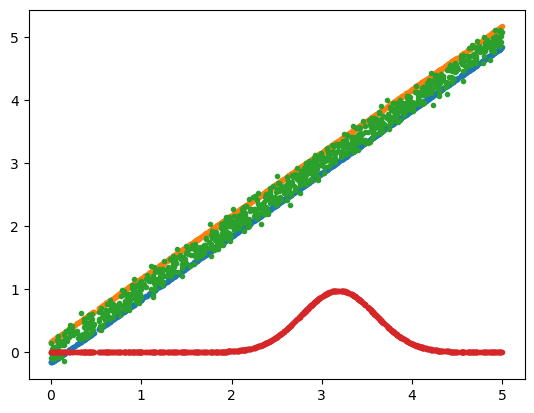

In [163]:
from auditor import Auditor
print(auditor.query_rkhs(weights))

from scipy.stats import norm
import matplotlib.pyplot as plt
plt.plot(X.flatten(), Z1.flatten(), '.')
plt.plot(X.flatten(), Z2.flatten(), '.')
plt.plot(X, Y, '.')
plt.plot(X.flatten(), norm.pdf(X.flatten(), loc=X[0], scale=np.sqrt(1/(2*gamma))), '.')

pdf = norm.pdf(X.flatten(), loc=X[0], scale=np.sqrt(1/(2*gamma)))
print(np.mean(pdf) * np.sqrt(np.mean(pdf**2)))

In [177]:
intervals = get_rectangles(X, discretization={0:[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]})

auditor.calibrate_groups(0.05, "upper", intervals, 
                         bootstrap_params={'student': 'prob_bound', 'student_threshold': 0.1**(3/2)})

print(auditor.query_group(intervals[:,0]))

auditor.calibrate_groups(0.05, "upper", intervals)
print(auditor.query_group(intervals[:,0]))


print(np.mean(intervals[:,1]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 8414.79it/s]


([array([0.60322901])], [0.8235294117647058])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 9462.53it/s]

([array([-3.32871972])], [0.8235294117647058])
0.09


In [114]:
print(X[intervals[:,7]].min(), X[intervals[:,7]].max())
print(X)

3.0331788788358995 3.981621351436471
[[3.18480844]
 [1.34893357]
 [0.20486762]
 [0.08263818]
 [4.0663512 ]
 [4.56377789]
 [3.03317888]
 [3.6474828 ]
 [2.71812496]
 [4.67536212]
 [4.07926777]
 [0.0136925 ]
 [4.28702138]
 [0.16792788]
 [3.64827723]
 [0.8782781 ]
 [4.31589461]
 [2.7073061 ]
 [1.49855945]
 [2.11343611]
 [0.14159836]
 [0.62141638]
 [3.35312207]
 [3.23594756]
 [3.07692556]
 [1.91838777]
 [4.98604968]
 [4.90417669]
 [3.42770992]
 [3.25229638]
 [3.44223365]
 [1.94460712]
 [0.67548253]
 [3.6074417 ]
 [2.62677161]
 [1.55120938]
 [2.42917679]
 [4.44743917]
 [4.67021758]
 [1.78897598]
 [2.85764915]
 [1.60934696]
 [2.97150015]
 [1.68955613]
 [1.958095  ]
 [4.45137176]
 [1.13578797]
 [3.11593572]
 [0.42007672]
 [4.16322074]
 [3.93549154]
 [1.19684721]
 [4.38242115]
 [0.29284017]
 [1.6805853 ]
 [0.75139733]
 [2.25169683]
 [3.98162135]
 [1.15321104]
 [0.26010651]
 [2.0227592 ]
 [0.99256522]
 [0.45376523]
 [2.90166193]
 [1.49348066]
 [3.35997439]
 [0.99757722]
 [4.71056555]
 [1.8255508

In [124]:
from sklearn.metrics.pairwise import pairwise_kernels
import numpy as np

n = 20
rng = np.random.default_rng(seed=1)
X = rng.uniform(0, 5, size=(n,1))

K = pairwise_kernels(X, metric="rbf") + 1e-5 * np.eye(n)
L = np.linalg.cholesky(K)

w = rng.multinomial(n, [1/n] * n, size=1).reshape(-1,1)

loss = rng.choice([0,1], p=[0.1, 0.9], size=(n,1))

ones = np.ones_like(w)

A = (w @ loss.T - ones @ (w * loss).T)
M = (A + A.T) / 2

In [125]:
Q, R = np.linalg.qr(np.concatenate((w, loss, ones, (w * loss)), axis=1))
B = Q.T @ M @ Q
P = L.T @ Q

P_tilde, R_tilde = np.linalg.qr(P)
B_tilde = R_tilde @ B @ R_tilde.T

target = L.T @ ones
c = np.linalg.norm(target)

v = P_tilde[:,0].reshape(-1,1) - (target / c)
v_n = v / np.linalg.norm(v)
hh_ref = np.eye(n) - 2 * v_n @ v_n.T

Q_tilde = hh_ref @ P_tilde

equiv_mat = P_tilde @ B_tilde @ P_tilde.T

B_star = Q_tilde.T @ equiv_mat @ Q_tilde
D, Q = np.linalg.eigh(B_star)

q = Q[0,:].reshape(-1,1)
print("done")
# sanity check
# print(np.isclose(Q @ B @ Q.T, M).all())

# sanity check (slow)
mat = L.T @ (M) @ L
print(np.isclose(Q_tilde @ B_star @ Q_tilde.T, mat).all())
print(np.linalg.eigvalsh(B_star).max())

done
True
10.470571445656292


In [126]:
n_samples = 1000000
S = rng.standard_normal(size=(n_samples,4))
S = S / np.linalg.norm(S, axis=1).reshape(-1,1)

obj_vals = (S.dot(B_star)*S).sum(axis=1)

print(obj_vals.max(), obj_vals.min())
import cvxpy as cp
from tqdm import tqdm
import copy


L_const = cp.Constant(L)
I = cp.Constant(np.eye(n))

proj = cp.Parameter((n, n))
sol_vec = cp.Parameter((n,))

x = cp.Variable(n)

constraints = [L_const @ (sol_vec + proj @ x) >= 0]
obj = cp.Minimize(cp.norm(x))

prob = cp.Problem(obj, constraints)
proj.value = np.eye(n) - Q_tilde @ Q_tilde.T

opt_vals = []
min_x = None
min_val = None
max_x = None
max_val = None
for i, val in enumerate(S):
    if val[0] < 0:
        continue
    sol_vec.value = Q_tilde @ val
    try:
        x_norm = prob.solve(solver="MOSEK", ignore_dpp=True)
    except cp.SolverError:
        continue

    opt_val = obj_vals[i] / (1 + x_norm)**2
    opt_vals.append(opt_val)
    if opt_val >= max(opt_vals):
        max_x = copy.deepcopy(x.value)
        max_val = val
    if opt_val <= min(opt_vals):
        min_x = copy.deepcopy(x.value)
        min_val = val
    if i % 100 == 0:
        print(i, max(opt_vals), min(opt_vals))
# %timeit prob.solve(solver='MOSEK')

10.46969059703616 -7.9607771307881645
100 7.514926739092291 -6.002083583510048
200 8.202528209585147 -7.683777472604643
300 8.202528209585147 -7.683777472604643
400 8.202528209585147 -7.683777472604643
600 8.551840256761066 -7.683777472604643
900 9.396219682215328 -7.683777472604643
1000 9.396219682215328 -7.683777472604643
1100 9.396219682215328 -7.683777472604643
1200 9.396219682215328 -7.683777472604643
1400 9.396219682215328 -7.683777472604643
1500 9.396219682215328 -7.683777472604643


KeyboardInterrupt: 

In [140]:
def get_nonneg_obj(seed):
    from sklearn.metrics.pairwise import pairwise_kernels
    import numpy as np

    n = 20
    rng = np.random.default_rng(seed=seed)
    X = rng.uniform(0, 5, size=(n,1))

    K = pairwise_kernels(X, metric="rbf") + 1e-5 * np.eye(n)
    L = np.linalg.cholesky(K)

    w = rng.multinomial(n, [1/n] * n, size=1).reshape(-1,1)

    loss = rng.choice([0,1], p=[0.1, 0.9], size=(n,1))

    ones = np.ones_like(w)

    A = (w @ loss.T - ones @ (w * loss).T)
    M = (A + A.T) / 2
    Q, R = np.linalg.qr(np.concatenate((w, loss, ones, (w * loss)), axis=1))
    B = Q.T @ M @ Q
    P = L.T @ Q

    P_tilde, R_tilde = np.linalg.qr(P)
    B_tilde = R_tilde @ B @ R_tilde.T

    target = L.T @ ones
    c = np.linalg.norm(target)

    v = P_tilde[:,0].reshape(-1,1) - (target / c)
    v_n = v / np.linalg.norm(v)
    hh_ref = np.eye(n) - 2 * v_n @ v_n.T

    Q_tilde = hh_ref @ P_tilde

    equiv_mat = P_tilde @ B_tilde @ P_tilde.T

    B_star = Q_tilde.T @ equiv_mat @ Q_tilde
    D, Q = np.linalg.eigh(B_star)
    print(D.max(), D.min())
    
    n_samples = 1000
    S = rng.standard_normal(size=(n_samples,4))
    S = S / np.linalg.norm(S, axis=1).reshape(-1,1)

    obj_vals = (S.dot(B_star)*S).sum(axis=1)

    import cvxpy as cp
    from tqdm import tqdm
    import copy


    L_const = cp.Constant(L)
    I = cp.Constant(np.eye(n))

    proj = cp.Parameter((n, n))
    sol_vec = cp.Parameter((n,))

    x = cp.Variable(n)

    constraints = [L_const @ (sol_vec + proj @ x) >= 0]
    obj = cp.Minimize(cp.norm(x))

    prob = cp.Problem(obj, constraints)
    proj.value = np.eye(n) - Q_tilde @ Q_tilde.T

    opt_vals = []
    min_x = None
    min_val = None
    max_x = None
    max_val = None
    for i, val in enumerate(S):
        if val[0] < 0:
            continue
        sol_vec.value = Q_tilde @ val
        try:
            x_norm = prob.solve(solver="MOSEK", ignore_dpp=True)
        except cp.SolverError:
            continue

        opt_val = obj_vals[i] / (1 + x_norm)**2
        opt_vals.append(opt_val)
        if opt_val >= max(opt_vals):
            max_x = copy.deepcopy(x.value)
            max_val = val
        if opt_val <= min(opt_vals):
            min_x = copy.deepcopy(x.value)
            min_val = val
#         if i % 100 == 0:
#             print(i, max(opt_vals), min(opt_vals))
    # %timeit prob.solve(solver='MOSEK')
    return max(opt_vals), min(opt_vals)
    
for seed in range(10):
    print(get_nonneg_obj(seed))

3.7855890173471547 -8.024951668536717
(0.6649927885835264, -7.862060887594572)
10.470571445656294 -7.963412070170087
(9.396219682215328, -7.683777472604643)
2.929653032930693 -9.010197728215289
(-0.0, -8.912151907476321)
0.0 0.0
(0.0, 0.0)
8.417105054236359 -4.379759981377445
(8.213535790446523, -3.348695100553903e-05)
4.2830760745321435 -12.068777147652495
(0.0, -11.856640671904005)
11.60387768249733 -9.055753411087105
(9.774810493191188, -8.7507692076374)
18.631391505452974 -3.2157350804950493
(18.50644654961399, -0.20006315427844365)
24.16559498081645 -3.934233192383774
(23.732951354541083, -2.1795210308781417e-05)
1.6468838853148375 -6.550231021272852
(1.6237074639303744, -6.117799765692768)


In [ ]:
vals = []
vals2 = []

def func(v):
    return (v.T @ B_star @ v).item() / (c * max(np.abs(v[0,0])**(3/2), 0.1**(3/2) / c))

def func2(v):
    return (v.T @ B_star @ v).item()# / (max(np.abs(v[0,0])**(3/2), 0.1**(3/2) / c))

for v in test:
    val = func(v.reshape(-1,1))
    val2 = func2(v.reshape(-1,1))
    vals.append(np.abs(val))
    vals2.append(np.abs(val2))
    
print(np.max(vals))
print(test[np.argmax(vals)])
v = test[np.argmax(vals)]
print(0.1/c)
print((max(np.abs(v[0]), 0.1 / c)))

print(np.max(vals2))
print(test[np.argmax(vals2)])

print(np.linalg.eigvalsh(B_star))

In [ ]:
import numpy as np

X = np.random.choice(np.arange(4), (500, 4))

n = X.shape[0]
p = X.shape[1]

coordinate_dummies = []
for c in range(p):
    unique_vals, indices = np.unique(X[:,c], return_inverse=True, axis=0)

    num_unique = len(unique_vals)
    # generate unique dummies
    unique_dummies = np.zeros((n, num_unique), dtype=int)
    unique_dummies[(range(n), indices)] = int(1)

    num_intervals = (num_unique * (num_unique + 1)) // 2
    interval_dummies = np.zeros((n, num_intervals), dtype=int)

    idx = num_unique
    add_dummies = np.cumsum(unique_dummies, axis=1, dtype=int)
    interval_dummies[:,0:idx] = add_dummies
    
    for c_prime in range(1, len(unique_vals)):
        # update dummies by subtracting out contribution from first unique dummy
        # and removing first column
        num_added = num_unique - c_prime
        add_dummies = add_dummies[:,1:num_unique] - add_dummies[:,0,None]
        interval_dummies[:,idx:(idx + num_added)] = add_dummies
        idx += num_added

    interval_dummies = interval_dummies.clip(max=int(1))
    coordinate_dummies.append(interval_dummies)

In [ ]:
chars = [chr(idx + 97) for idx in range(p)]
einsum_str = ','.join(f'i{c}' for c in chars)
einsum_str += '->i' + ''.join(chars)
group_dummies = np.einsum(einsum_str, *coordinate_dummies, )
group_dummies = group_dummies.reshape(n, -1, order='C')

In [ ]:
def run_test(**kwargs):
    print(kwargs)
    
np.asarray([(1,2), (3, 3)])

In [ ]:
np.all(group_dummies_unpacked == group_dummies)

In [ ]:
from itertools import product

def run_trial():
    num_intervals = [range(interval_dummies.shape[1]) for interval_dummies in coordinate_dummies]
    group_indices = list(product(*num_intervals))

    num_groups = len(group_indices)

    group_dummies = np.zeros((n, num_groups), dtype=int)
    final_arr = np.ones((n, 1), dtype=int)

    for i, g_index in enumerate(group_indices):
        for j, g_i in enumerate(g_index):
            final_arr *= coordinate_dummies[j][:,g_i,None]
        group_dummies[:,i] = final_arr.flatten()
        final_arr = 1
    return group_dummies
        
group_dummies = run_trial()

In [ ]:
group_dummies

In [ ]:
test.reshape(3, -1)